Download dataset:

https://drive.google.com/drive/folders/14gZLQPipqwgO_Jf2lzod4WqQSG4j1kqp?usp=sharing

https://www.dropbox.com/s/hffpj5u8rjfolkk/combcirc.zip?dl=0

With edge labels

https://www.dropbox.com/s/r3jylavm9nvjlds/combcirc.zip?dl=0

In [1]:
# !cp -r drive/MyDrive/public/verilog_to_graph .
# !cp -r drive/MyDrive/public/verilog_dataset_fixed.zip .
# !cp -r drive/MyDrive/public/combcirc_v02.zip .

In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q pyg_lib -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118


In [3]:
import random
import numpy as np

In [4]:
def seed_everything(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(12345)

In [5]:
import shutil
import os.path as osp
from typing import Callable, Optional

import torch
from torch_geometric.data import InMemoryDataset, download_url, extract_zip
from torch_geometric.io import read_tu_data

In [6]:
class CombcircDataset(InMemoryDataset):
    def __init__(
        self,
        root: Optional[str] = None,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        log: bool = True,
        name: str = 'combcirc',
    ):
        self.name = name
        self.url = 'https://www.dropbox.com/s/r3jylavm9nvjlds/combcirc.zip?dl=1'

        super().__init__(root, transform, pre_transform, pre_filter, log)

        self.data, self.slices, self.sizes = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        names = ['A', 'graph_indicator', 'graph_attributes', 'node_labels', 'edge_labels']
        return [f'{self.name}_{name}.txt' for name in names]

    @property
    def processed_file_names(self):
        return ['data.pt']

    @property
    def num_node_labels(self) -> int:
        return self.sizes['num_node_labels']

    @property
    def num_node_attributes(self) -> int:
        return self.sizes['num_node_attributes']

    @property
    def num_edge_labels(self) -> int:
        return self.sizes['num_edge_labels']

    @property
    def num_edge_attributes(self) -> int:
        return self.sizes['num_edge_attributes']

    def download(self):
        folder = osp.join(self.root, self.name)
        path = download_url(self.url, folder)
        extract_zip(path, folder)
        os.unlink(path)
        shutil.rmtree(self.raw_dir)
        os.rename(folder, self.raw_dir)

    def process(self):
        self.data, self.slices, sizes = read_tu_data(self.raw_dir, self.name)

        if self.pre_filter is not None or self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]

            if self.pre_filter is not None:
                data_list = [d for d in data_list if self.pre_filter(d)]

            if self.pre_transform is not None:
                data_list = [self.pre_transform(d) for d in data_list]

            self.data, self.slices = self.collate(data_list)
            self._data_list = None  # Reset cache.

        torch.save((self._data, self.slices, sizes), self.processed_paths[0])

In [7]:
%%time

dataset = CombcircDataset(
    root='dataset-root',
    log=True,
    name='combcirc',
)

CPU times: user 0 ns, sys: 3.24 s, total: 3.24 s
Wall time: 6.67 s


In [8]:
print(dataset)
print('dataset.num_node_labels:', dataset.num_node_labels)
print('dataset.num_node_attributes:', dataset.num_node_attributes)
print('dataset.num_edge_labels:', dataset.num_edge_labels)
print('dataset.num_edge_attributes:', dataset.num_edge_attributes)

CombcircDataset(32699)
dataset.num_node_labels: 11
dataset.num_node_attributes: 0
dataset.num_edge_labels: 66
dataset.num_edge_attributes: 0


In [9]:
data = dataset.get(0)
print(data)
print('data.num_edge_features:', data.num_edge_features)
print('data.num_features:', data.num_features)
print('data.num_node_features:', data.num_node_features)

Data(edge_index=[2, 278], x=[248, 11], edge_attr=[278, 66], y=[1])
data.num_edge_features: 66
data.num_features: 11
data.num_node_features: 11


In [10]:
dataset = dataset.shuffle()

fraction = 0.8
train_num = int(fraction * len(dataset))

train_dataset = dataset[:train_num]
test_dataset = dataset[train_num:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 26159
Number of test graphs: 6540


In [11]:
from torch_geometric.loader import DataLoader

In [12]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [13]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels, improved=True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, improved=True)
        self.conv3 = GCNConv(hidden_channels, hidden_channels, improved=True)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final regressor
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x.flatten()

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(11, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


A Google Colab thing

In [15]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

In [16]:
def train(model, device, train_loader, criterion, enable_edge_attr=False):
    model = model.to(device)
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        if enable_edge_attr:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        else:
            out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.


def test(model, device, loader, criterion, return_loss_list=False, enable_edge_attr=False):
    model = model.to(device)
    model.eval()

    loss_list = []
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            if enable_edge_attr:
                out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            else:
                out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
            loss = criterion(out, data.y, reduction='none')  # Compute the loss.
            loss_list.append(loss.detach().cpu())

        loss_mean = torch.mean(torch.cat(loss_list)).item()

    if return_loss_list:
        return loss_mean, loss_list
    else:
        return loss_mean

In [17]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
criterion = F.mse_loss
n_epochs = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
epoch_train_losses = []
epoch_test_losses = []

for epoch in range(1, n_epochs):
    train(model, device, train_loader, criterion)

    train_loss = test(model, device, train_loader, criterion)
    epoch_train_losses.append(train_loss)

    test_loss = test(model, device, test_loader, criterion)
    epoch_test_losses.append(test_loss)
    scheduler.step(test_loss)

    clear_output()

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.5f}, Test loss: {test_loss:.5f}')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    fig.suptitle('GCNConv')
    
    axes[0].plot(epoch_train_losses, '-o')
    axes[0].set_xlabel('Epoch number')
    axes[0].set_ylabel('Train loss')
    # axes[0].set_xticks(np.arange(len(epoch_train_losses))[::len(epoch_train_losses)//20])
    
    axes[1].plot(epoch_test_losses, '-o')
    axes[1].set_xlabel('Epoch number')
    axes[1].set_ylabel('Test loss')
    # axes[1].set_xticks(np.arange(len(epoch_test_losses))[::len(epoch_test_losses)//20])

    plt.show()

In [ ]:
def describe(arr):
    # measures of central tendency
    mean = np.mean(arr)
    median = np.median(arr)

    # measures of dispersion
    min = np.amin(arr)
    max = np.amax(arr)
    range = np.ptp(arr)
    variance = np.var(arr)
    sd = np.std(arr)

    print("Descriptive analysis")
    print("Array =", arr)
    print("Measures of Central Tendency")
    print("Mean =", mean)
    print("Median =", median)
    print("Measures of Dispersion")
    print("Minimum =", min)
    print("Maximum =", max)
    print("Range =", range)
    print("Variance =", variance)
    print("Standard Deviation =", sd)

In [ ]:
criterions = {
    'mse': F.mse_loss,
    'mae': F.l1_loss,
}
losses = {}
for crit_label, crit in criterions.items():
    test_loss = test(model, device, test_loader, crit)
    losses[crit_label] = test_loss
    print(f'Test {crit_label}: {test_loss:.5f}')

In [ ]:
torch.save(model, f'GCN_{losses["mse"]:.5f}_{losses["mae"]:.5f}.pt')

## GATConv

In [19]:
from torch_geometric.nn import GATv2Conv

In [20]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATv2Conv(dataset.num_node_features, hidden_channels, edge_dim=dataset.num_edge_features)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels, edge_dim=dataset.num_edge_features)
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels, edge_dim=dataset.num_edge_features)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final regressor
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x.flatten()

model = GAT(hidden_channels=64)
print(model)

GAT(
  (conv1): GATv2Conv(11, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (conv3): GATv2Conv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [21]:
model = GAT(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
criterion = F.mse_loss
n_epochs = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Epoch: 084, Train Loss: 0.07812, Test loss: 0.08031, lr: 1.0000000000000004e-08


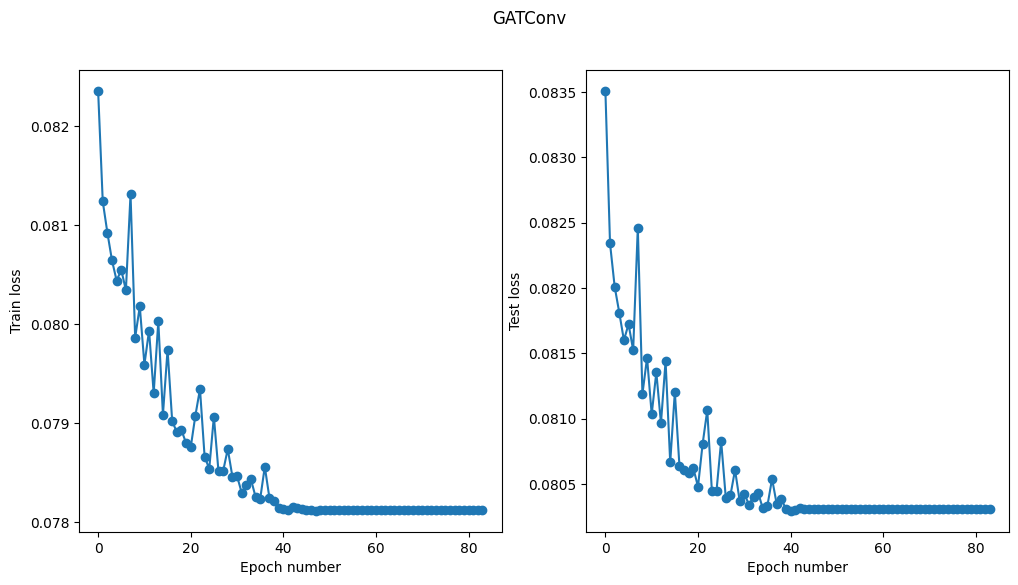

KeyboardInterrupt: 

In [22]:
epoch_train_losses = []
epoch_test_losses = []

for epoch in range(1, n_epochs):
    train(model, device, train_loader, criterion, enable_edge_attr=True)

    train_loss = test(model, device, train_loader, criterion, enable_edge_attr=True)
    epoch_train_losses.append(train_loss)

    test_loss = test(model, device, test_loader, criterion, enable_edge_attr=True)
    epoch_test_losses.append(test_loss)

    clear_output()
    
    scheduler.step(test_loss)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.5f}, Test loss: {test_loss:.5f}, lr: {optimizer.param_groups[0]["lr"]}')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    fig.suptitle('GATConv')
    
    axes[0].plot(epoch_train_losses, '-o')
    axes[0].set_xlabel('Epoch number')
    axes[0].set_ylabel('Train loss')
    # axes[0].set_xticks(np.arange(len(epoch_train_losses))[::len(epoch_train_losses)//20])
    
    axes[1].plot(epoch_test_losses, '-o')
    axes[1].set_xlabel('Epoch number')
    axes[1].set_ylabel('Test loss')
    # axes[1].set_xticks(np.arange(len(epoch_test_losses))[::len(epoch_test_losses)//20])

    plt.show()

In [24]:
criterions = {
    'mse': F.mse_loss,
    'mae': F.l1_loss,
}
losses = {}
for crit_label, crit in criterions.items():
    test_loss = test(model, device, test_loader, crit, enable_edge_attr=True)
    losses[crit_label] = test_loss
    print(f'Test {crit_label}: {test_loss:.5f}')

Test mse: 0.08031
Test mae: 0.24179


In [25]:
torch.save(model, f'GATv2_{losses["mse"]:.5f}_{losses["mae"]:.5f}.pt')

## TransformerConv

In [26]:
from torch_geometric.nn import TransformerConv

In [27]:
class Transformer(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = TransformerConv(dataset.num_node_features, hidden_channels, edge_dim=dataset.num_edge_features)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels, edge_dim=dataset.num_edge_features)
        self.conv3 = TransformerConv(hidden_channels, hidden_channels, edge_dim=dataset.num_edge_features)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final regressor
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x.flatten()

model = Transformer(hidden_channels=64)
print(model)

Transformer(
  (conv1): TransformerConv(11, 64, heads=1)
  (conv2): TransformerConv(64, 64, heads=1)
  (conv3): TransformerConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [28]:
model = Transformer(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
criterion = F.mse_loss
n_epochs = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Epoch: 068, Train Loss: 0.07773, Test loss: 0.07983, lr: 1.0000000000000004e-08


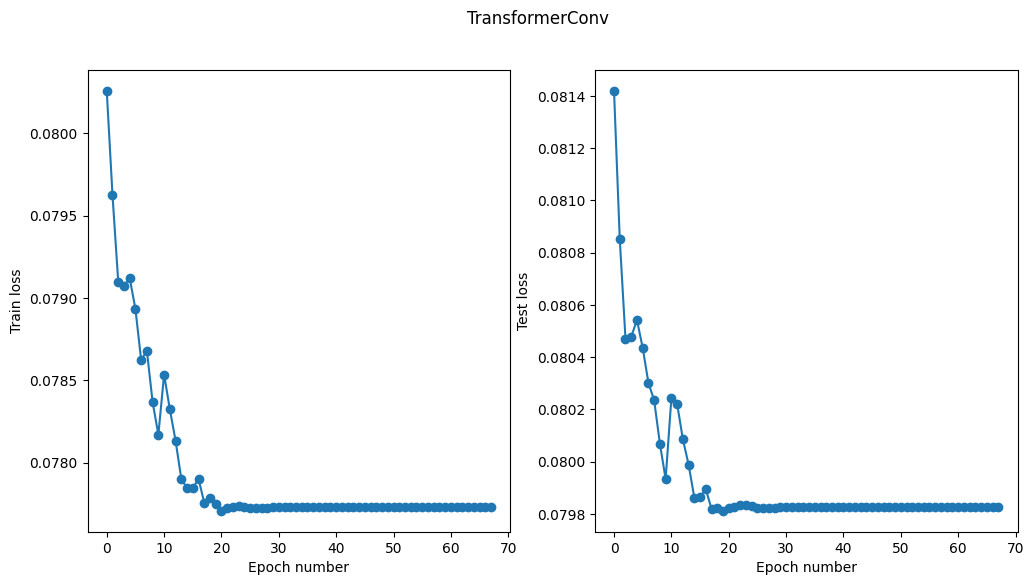

KeyboardInterrupt: 

In [29]:
epoch_train_losses = []
epoch_test_losses = []

for epoch in range(1, n_epochs):
    train(model, device, train_loader, criterion, enable_edge_attr=True)

    train_loss = test(model, device, train_loader, criterion, enable_edge_attr=True)
    epoch_train_losses.append(train_loss)

    test_loss = test(model, device, test_loader, criterion, enable_edge_attr=True)
    epoch_test_losses.append(test_loss)

    clear_output()
    
    scheduler.step(test_loss)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.5f}, Test loss: {test_loss:.5f}, lr: {optimizer.param_groups[0]["lr"]}')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    fig.suptitle('TransformerConv')
    
    axes[0].plot(epoch_train_losses, '-o')
    axes[0].set_xlabel('Epoch number')
    axes[0].set_ylabel('Train loss')
    # axes[0].set_xticks(np.arange(len(epoch_train_losses))[::len(epoch_train_losses)//20])
    
    axes[1].plot(epoch_test_losses, '-o')
    axes[1].set_xlabel('Epoch number')
    axes[1].set_ylabel('Test loss')
    # axes[1].set_xticks(np.arange(len(epoch_test_losses))[::len(epoch_test_losses)//20])

    plt.show()

In [30]:
criterions = {
    'mse': F.mse_loss,
    'mae': F.l1_loss,
}
losses = {}
for crit_label, crit in criterions.items():
    test_loss = test(model, device, test_loader, crit, enable_edge_attr=True)
    losses[crit_label] = test_loss
    print(f'Test {crit_label}: {test_loss:.5f}')

Test mse: 0.07983
Test mae: 0.24095


In [32]:
torch.save(model, f'TransformerConv_{losses["mse"]:.5f}_{losses["mae"]:.5f}.pt')